<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/0530_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 분류: 의류 이미지 분류

운동화나 셔츠 같은 옷 이미지를 분류하는 신경망 모델을 훈련

* 텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 tf.keras를 사용

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


## 패션 MNIST 데이터셋 임포트하기

* 10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용
  - 이미지는 해상도(28x28 픽셀)가 낮은 개별 옷 품목


* 60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가

TensorFlow에서 직접 Fashion MNIST 데이터를 가져오고 로드

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


> load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환:
  - `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 *훈련 세트*
  - `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 *테스트 세트*

* 이미지는 28x28 크기의 넘파이 배열
  - 픽셀 값은 0과 255 사이
* *레이블*(label)은 0에서 9까지의 정수 배열
  - 각 이미지는 하나의 레이블에 매핑
  - 이미지에 있는 옷의 *클래스*(class):

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

클래스 이름을 별도의 변수를 만들어 저장
  - 데이터셋에 클래스 이름이 들어있지 않기 때문

    -> 나중에 이미지를 출력할 때 사용

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 데이터 탐색

데이터셋 구조 확인

In [4]:
train_images.shape

(60000, 28, 28)

> 훈련 세트 : 60,000개의 이미지
  - 각 이미지는 28x28 픽셀로 표현

In [5]:
len(train_labels)

60000

> 훈련 세트 : 60,000개의 레이블

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

> 각 레이블은 0과 9사이의 정수

In [7]:
test_images.shape

(10000, 28, 28)

> 테스트 세트 : 10,000개의 이미지
  - 이 이미지도 28x28 픽셀로 표현

In [8]:
len(test_labels)

10000

> 테스트 세트 : 10,000개의 이미지에 대한 레이블

## 데이터 전처리

훈련 세트에 있는 첫 번째 이미지 확인
  - 픽셀 값의 범위 : 0~255 사이

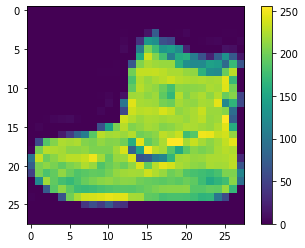

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정
  - 255로 나누어야 함
  - *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력

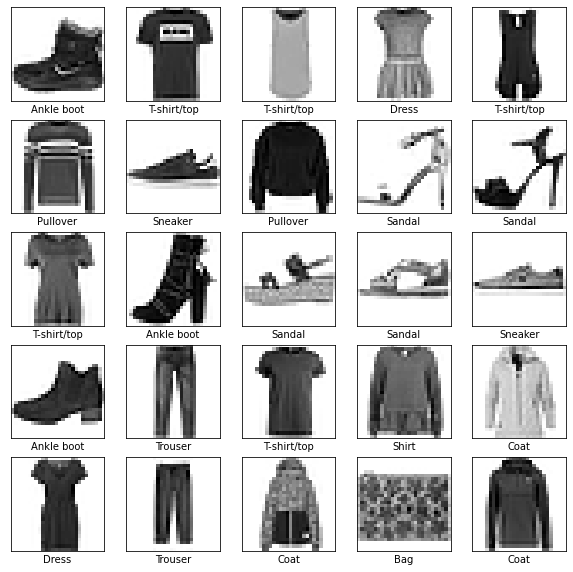

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일

### 층 설정

* 레이어 : 신경망의 기본 빌딩 블록
  - 레이어에 공급된 데이터로부터 표현을 추출 -> 표현은 당면한 문제에 의미가 있어야 함

* 대부분 딥러닝은 간단한 층을 연결하여 구성 : `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

> 첫 번째 층 `tf.keras.layers.Flatten` : 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환
  - 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘림
  - 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 함
>
> 픽셀을 펼친 후에는 두 개의 `tf.keras.layers.Dense` 층이 연속되어 연결
  - 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부름
    - 첫 번째 `Dense` 층 : 128개의 노드(또는 뉴런)
    - 두 번째 (마지막) 층 : 10개의 노드의 *소프트맥스*(softmax) 층
      - 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1
      - 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력

### 모델 컴파일

모델의 컴파일 단계에서 몇 가지 설정 추가

- 손실 함수 : 훈련 중 모델이 얼마나 정확한지 측정, 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 함
- 옵티마이저 : 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식
- 메트릭 : 훈련 및 테스트 단계를 모니터링하는 데 사용
  - 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도*를 사용

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 훈련

신경망 모델을 훈련하려면 다음 단계가 필요

1. 훈련 데이터를 모델에 주입
  - 이 예에서는 `train_images`와 `train_labels` 배열
2. 모델이 이미지와 레이블을 매핑하는 방법을 학습
3. 테스트 세트에 대한 모델의 예측을 생성
  - 이 예에서는 `test_images` 배열 -> 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인
4. 예측이 `test_labels` 배열의 레이블과 일치하는지 확인


### 모델 피드

훈련을 시작하려면 `model.fit` 메서드를 호출

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4955 - accuracy: 0.8260
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3727 - accuracy: 0.8651
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3355 - accuracy: 0.8774
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3113 - accuracy: 0.8859
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2961 - accuracy: 0.8919
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2802 - accuracy: 0.8954
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2670 - accuracy: 0.8992
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2587 - accuracy: 0.9042
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2462 - accuracy: 0.9092
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.239

> 모델이 훈련되면서 손실과 정확도 지표가 출력
>
> 이 모델은 훈련 세트에서 약 0.91(91%) 정도의 정확도를 달성

### 정확도 평가

모델이 테스트 데이터세트에서 작동하는 방식을 비교

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3334 - accuracy: 0.8833 - 624ms/epoch - 2ms/step

Test accuracy: 0.8833000063896179


> 테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮음
  - 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문
    - 과대적합 : 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

### 예측하기

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행
  - 모델의 선형 출력, 로짓. 소프트맥스 레이어를 연결하여 로짓을 해석하기 쉬운 확률로 변환

In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_images)

테스트 세트에 있는 각 이미지의 레이블을 예측

In [18]:
predictions[0] # 첫 번째 예측 확인

array([1.3454675e-08, 8.9586685e-11, 3.1677869e-10, 1.3828218e-10,
       3.1993011e-10, 6.2556722e-04, 2.4310257e-08, 1.2692926e-02,
       3.3338534e-07, 9.8668110e-01], dtype=float32)

> 이 예측은 10개의 숫자 배열
>
> 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄

첫 번째 예측에서 가장 높은 신뢰도를 가진 레이블 확인

In [19]:
np.argmax(predictions[0])

9

> 모델은 이 이미지가 앵클 부츠(`class_name[9]`)라고 가장 확신

테스트 레이블 확인

In [20]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 예측 확인

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인

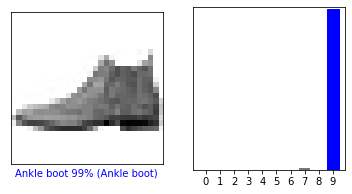

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

12번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인

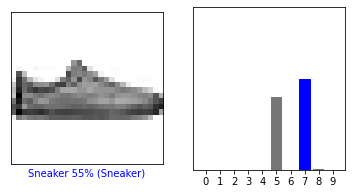

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력
  - 올바르게 예측된 레이블은 파란색, 잘못 예측된 레이블은 빨간색
  - 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)
  - 신뢰도 점수가 높을 때도 잘못 예측할 수 있음

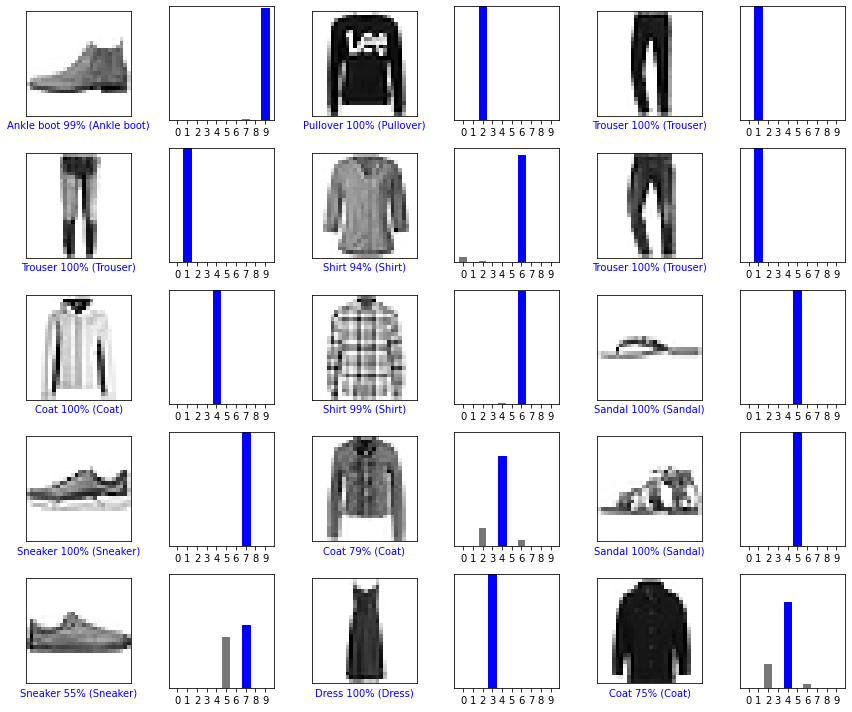

In [24]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 훈련된 모델 사용하기

훈련된 모델을 사용하여 한 이미지에 대한 예측 생성

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


* `tf.keras` 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화
  
  -> 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 함

In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


이미지의 예측 생성

In [27]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[1.8049257e-05 1.8911585e-12 9.9926800e-01 1.3303039e-09 2.6308803e-04
  1.4001417e-10 4.5092645e-04 4.6139780e-16 8.9712273e-09 5.6707681e-12]]


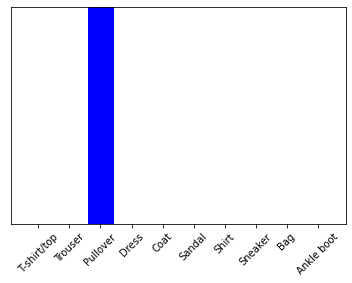

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

* `tf.keras.Model.predict`는 데이터 배치의 각 이미지에 대해 하나의 목록을 반환
  - 배치에서 (유일한) 이미지에 대한 예측을 가져옴

In [29]:
np.argmax(predictions_single[0])

2

> 예상과 같이 모델이 레이블을 예측